# Lithium Oven Optic 6

In [14]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from ionization import ionization
from lens import profile
from lens import design
import matplotlib.pyplot as plt
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
lam = 0.796
# All length units are in um

75um radius Bessel to make the widest fully ionized Bessel beam possible (see Plasma Width for details). Slightly ramping intensity profile for best performance. Plasma is approximatly 300um wide and fully ionized in the bulk. Optic 6 is meant to be the first iteration we actually make a physical version of.

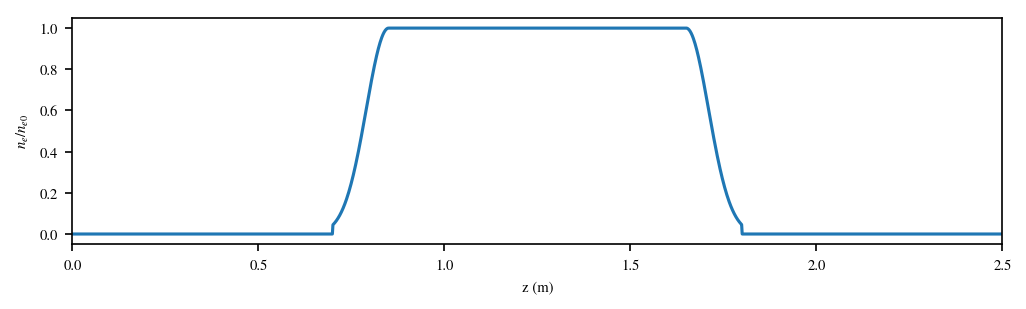

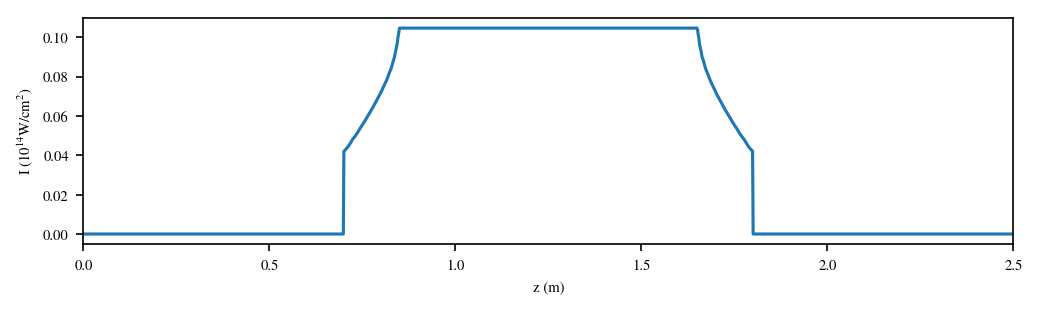

Plasma starts at 0.32m and ends at 2.25m


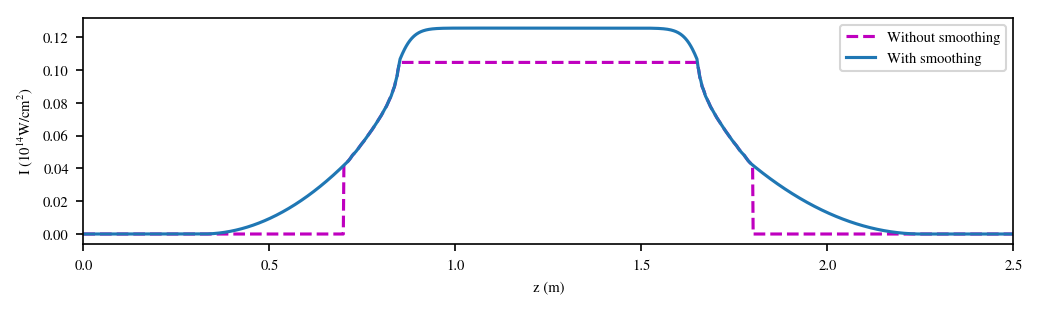

In [2]:
length = 80e4
width = 75
Nz = 2**16
Z = 100e6
z0 = 0.85e6
xlim = [0, 2.5]
tau = 30 # RMS pulse length in fs
ion = {'atom' : ionization.Li,
       'tau' : tau,
       'type' : 'gaussian'}
z, I_la = profile.cutoff_gaussian_intensity(Nz, Z, z0, length, 15e4, 6e4, 15e4, 6e4, ion, 8, 0.4, path, xlim)

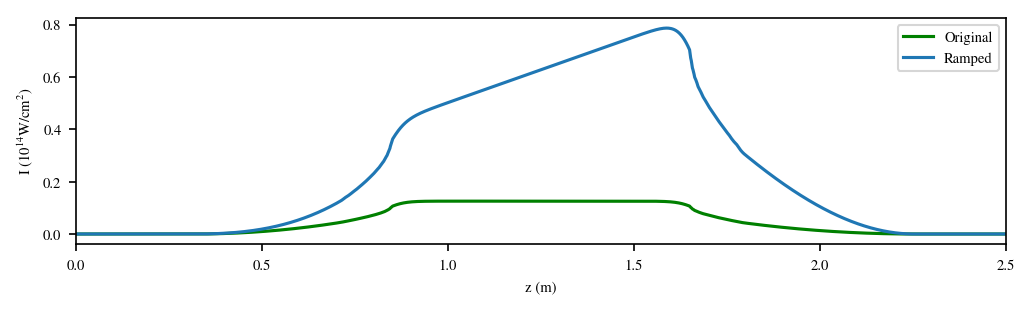

In [3]:
# Add a ramped intensity profile
I_ramped = abs(4*I_la*(1e-6*(z-1e6)+1))
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z/1e6, I_la, 'g')
plt.plot(z/1e6, I_ramped)
plt.legend(['Original', 'Ramped'])
plt.xlabel(r'z (m)')
plt.ylabel(r'I ($\mathrm{10^{14}W/cm^2}$)')
plt.xlim(xlim)
plt.show()
np.save(path+'intensity.npy', I_ramped)
np.save(path+'z.npy', z)

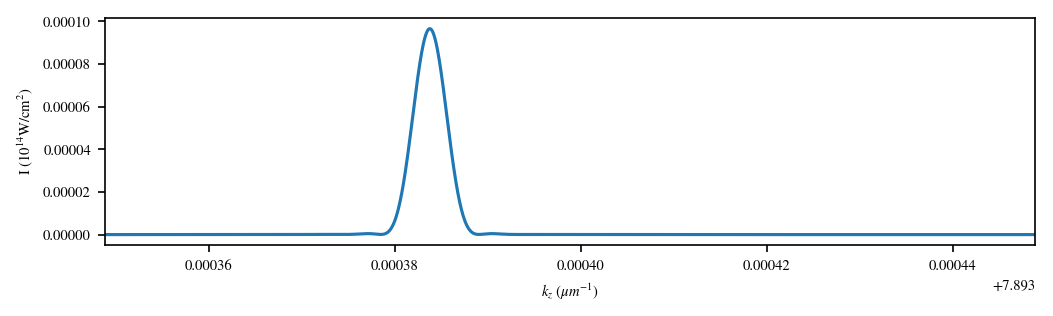

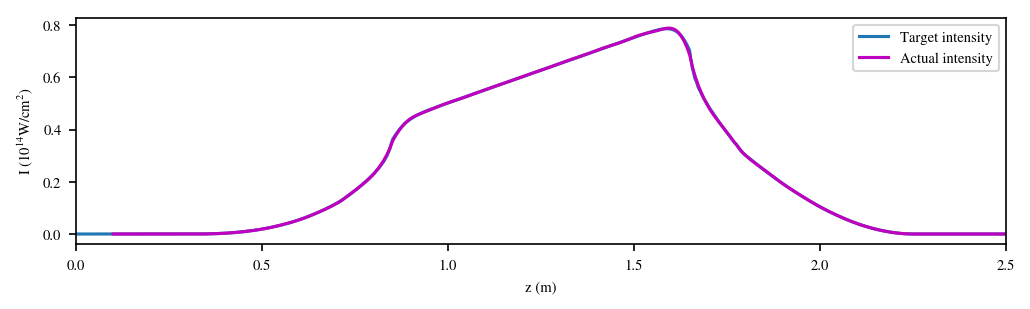

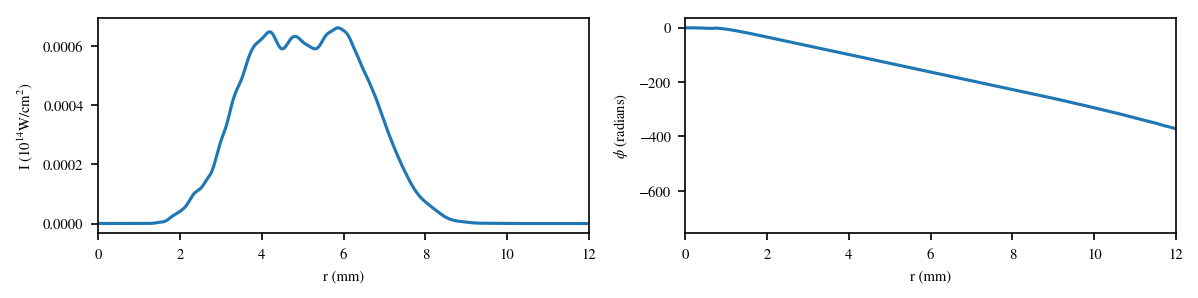

In [4]:
r, E = design.calculate_tran_field(z, I_ramped, 20e3, width, lam, path, 10e-5, xlim, [0, 12])

In [5]:
# Create the gas density the laser is going into
ne0 = 3.4e16/1e17
sim_start, n_plot, n = profile.lithium_oven_profile(z, 1.25e6, ne0)
sim_length = 80e4
np.save(path+'sim_size.npy', [sim_start, sim_length])

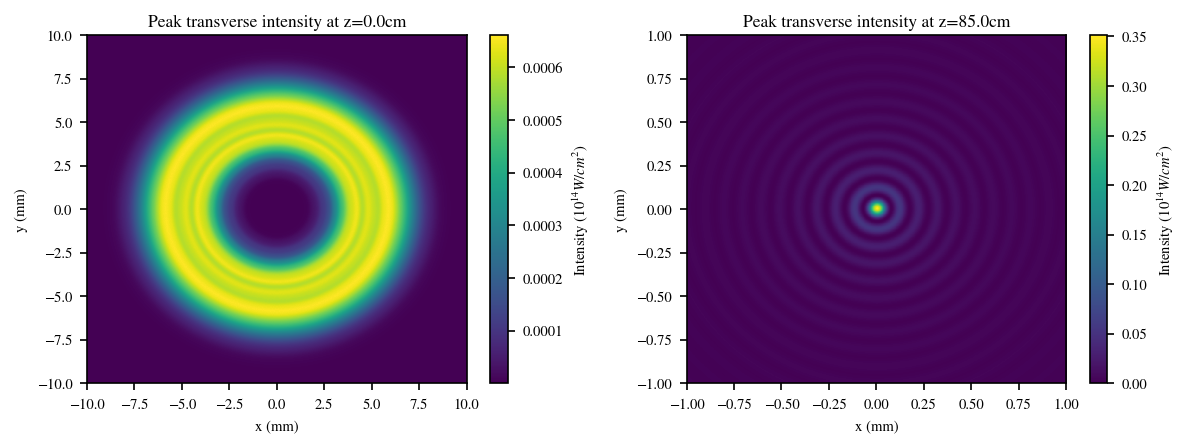

In [6]:
X = 20e3
Nx = 2**13
beam0, pulseParams = design.propagate_to_start(r, E, sim_start, X, Nx, path, lam, tau, 20, [-1, 1])

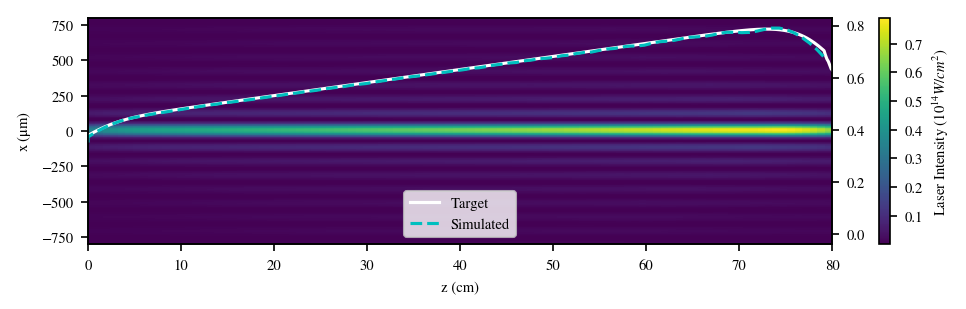

In [7]:
Nx = 2**11
Nz = 100
X = 10e3
design.domain_test(X, Nx, sim_length, Nz, beam0, pulseParams, z, I_ramped, sim_start, [-800, 800]);

In [ ]:
Nx = 2**11
Nz = 400
ext = [0, sim_length/1e4, -X/2, X/2]
plt.style.use('presentation')
pulse, I, ne = design.plasma_refraction(X, Nx, sim_length, Nz, beam0,pulseParams,ionization.Li,n, sim_start, 1)
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[20, 40, 60])

In [ ]:
pulse.pulse_energy()

In [ ]:
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[20, 40, 60])

In [ ]:
design.plot_laser_plasma(I, ne, ext)

Initial pulse energy 5.79mJ
Final pulse energy 4.71mJ


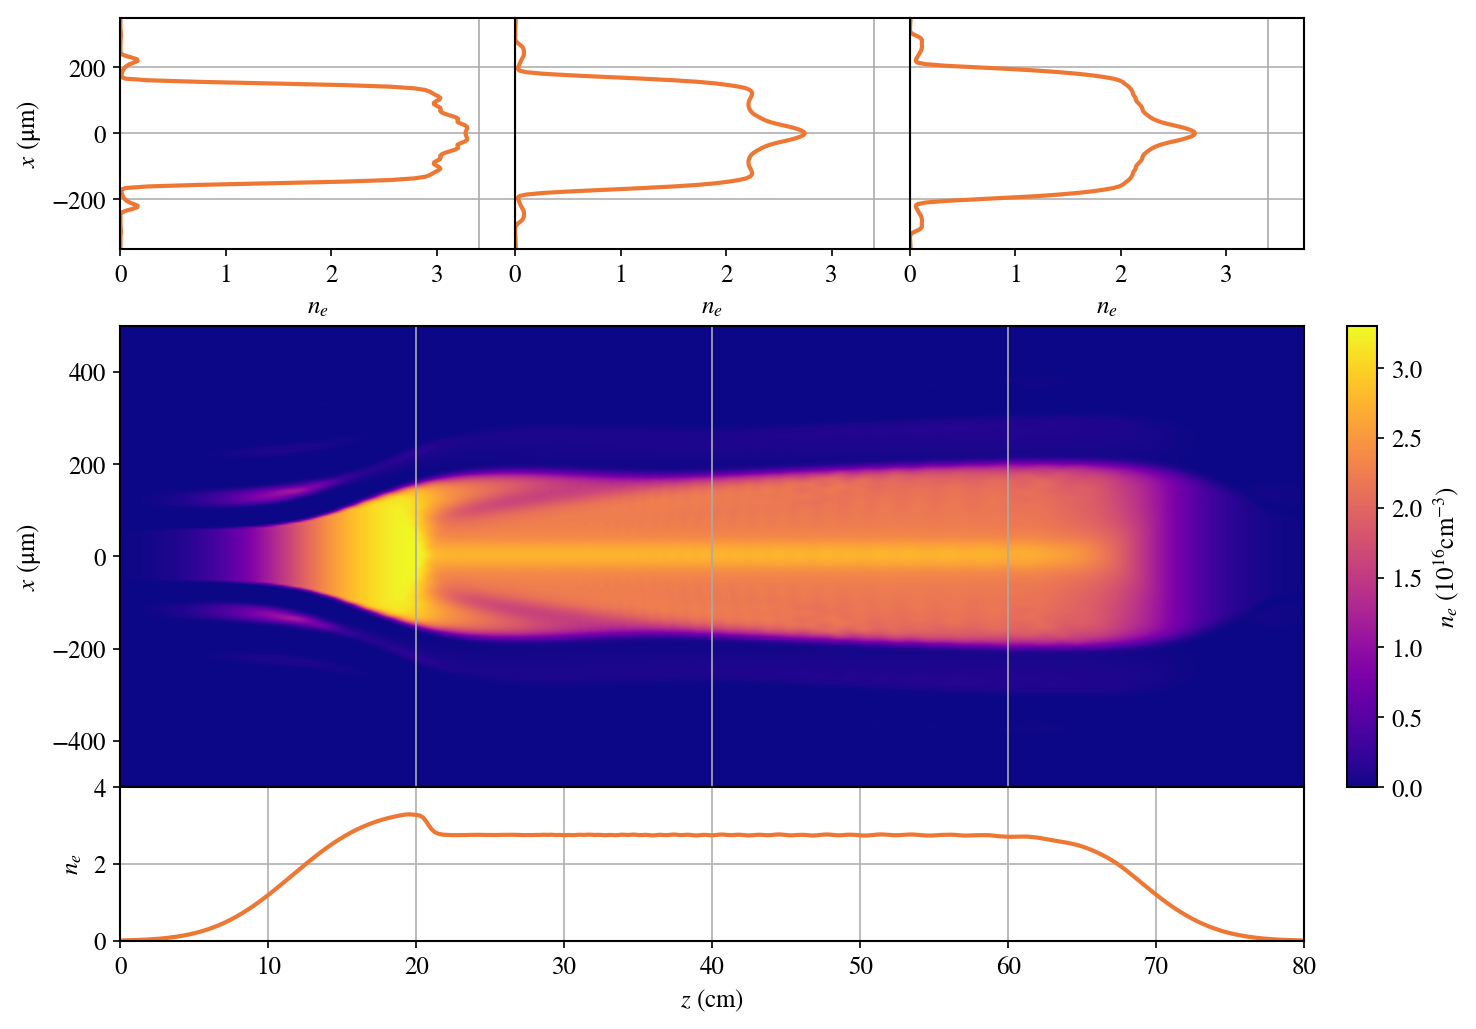

In [8]:
Nx = 2**11
Nz = 400
ext = [0, sim_length/1e4, -X/2, X/2]
plt.style.use('presentation')
pulseParams['tau'] = 70
pulseParams['T'] = 3*70
pulseParams['Nt'] = 2**7
pulse, I, ne = design.plasma_refraction(X, Nx, sim_length, Nz, beam0,pulseParams,ionization.Li,n, sim_start, 1,
                                       ne0)
design.plot_plasma_density(pulse, ne, ne0, ext, lines=[20, 40, 60])

In [9]:
pulse.pulse_energy()

0.0047108796534425451

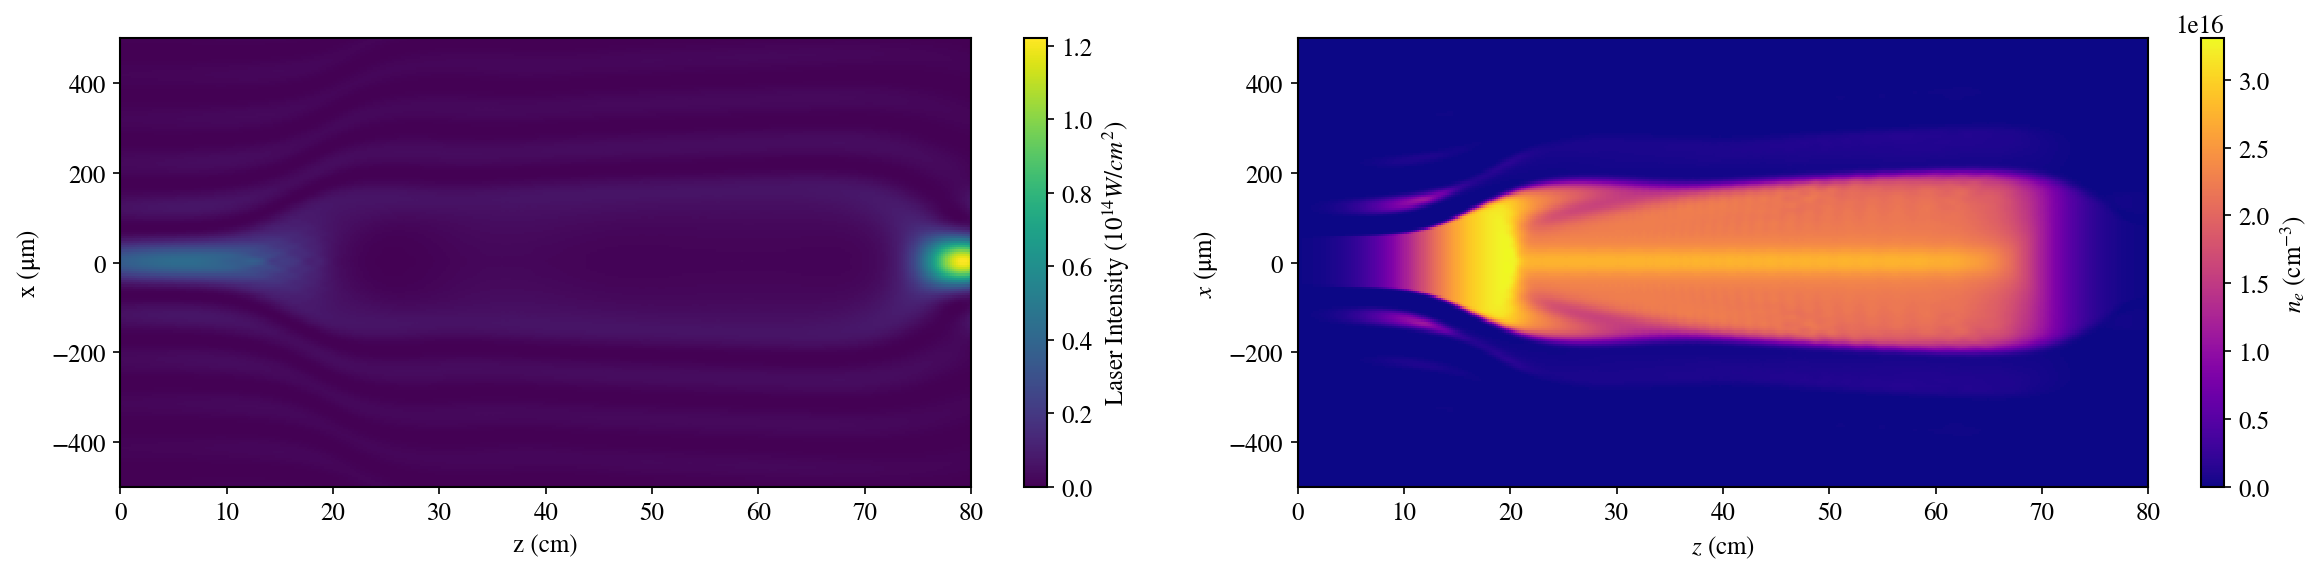

In [10]:
plt.style.use('presentation')
design.plot_laser_plasma(I, ne, ext)

In [20]:
from lens import design
plt.style.use('notes')
design.pulse_evolution(pulse, 'Lithium_Oven_Pulse', ylim=[-500, 500], smooth=True)

Frame 30 completed
Frame 60 completed
Frame 90 completed
Frame 120 completed
Frame 150 completed
Frame 180 completed
Frame 210 completed
Frame 240 completed
Frame 270 completed
Frame 300 completed
Frame 330 completed
Frame 360 completed
Frame 390 completed


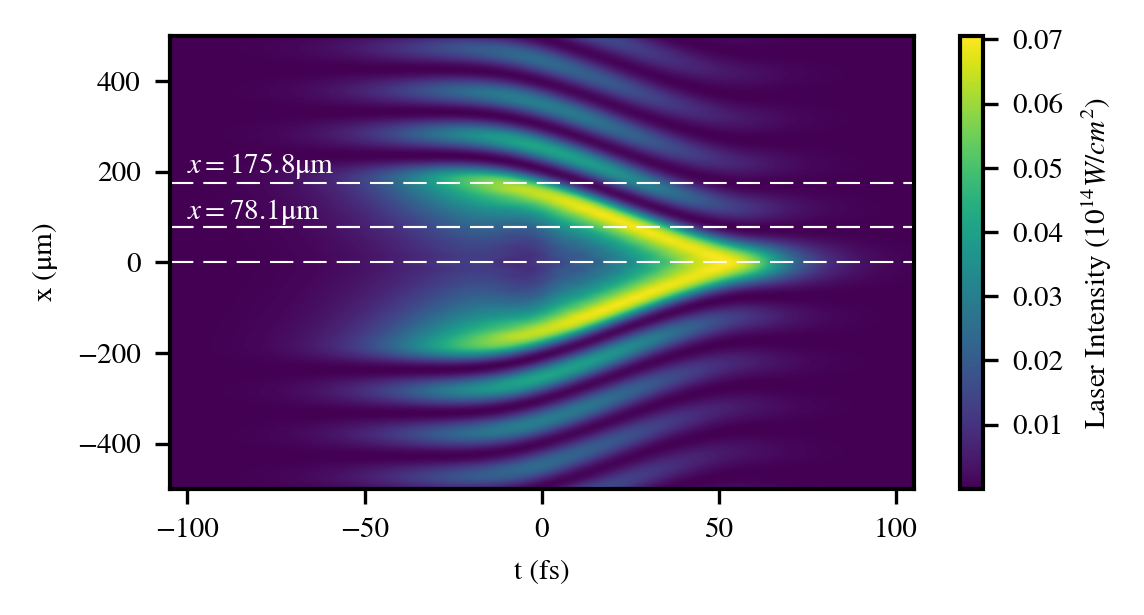

In [99]:
ind = 250
Nt = pulse.Nt
T = pulse.T
Nx = pulse.Nx
X = pulse.X
e = np.zeros((Nt, Nx), dtype='complex128')
e[:, :] = pulse.load_field(ind)[0]
I = ionization.intensity_from_field(e)
I_max = np.amax(I)
dx = X/(Nx-1)

ext = [-T/2, T/2, -X/2, X/2-dx]
plt.figure(figsize=(4, 2), dpi=300)
plt.imshow(np.fliplr(np.flipud(np.transpose(I))), aspect='auto', extent=ext, cmap='viridis', 
           interpolation='Spline16')
plt.plot([-105, 105], [0, 0], 'w--', linewidth=0.5)
plt.plot([-105, 105], [78.1, 78.1], 'w--', linewidth=0.5)
plt.plot([-105, 105], [78.1, 78.1], 'w--', linewidth=0.5)
plt.plot([-105, 105], [175.8, 175.8], 'w--', linewidth=0.5)
plt.text(-100, 95, r'$x=78.1\mathrm{\mu m}$', color='w')
plt.text(-100, 198, r'$x=175.8\mathrm{\mu m}$', color='w')
cb = plt.colorbar(format="%0.2f")
cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.xlabel('t (fs)')
plt.ylabel(r'x ($\mathrm{\mu m}$)')
plt.ylim([-500, 500])
plt.show()

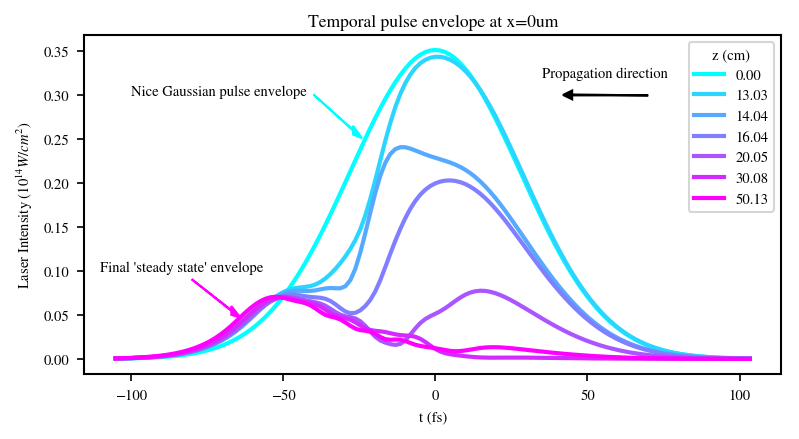

In [21]:
ind = np.array([0, 65, 70, 80, 100, 150, 250])

Nt = pulse.Nt
T = pulse.T
t = pulse.t
Nx = pulse.Nx
X = pulse.X
e = np.zeros((Nt, Nx), dtype='complex128')

i_x = int(Nx/2)

plt.figure(figsize=(6, 3), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(ind))]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
for i in range(len(ind)):
    e[:, :] = pulse.load_field(ind[i])[0]
    I = ionization.intensity_from_field(e)
    I_max = np.amax(I)
    plt.plot(t, I[:, i_x], label='%0.2f' % (pulse.z[ind[i]]/1e4))
plt.legend(title='z (cm)')
plt.xlabel('t (fs)')
plt.ylabel(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.text(-100, 0.3, 'Nice Gaussian pulse envelope')
plt.arrow(-40, 0.3, 13, -0.04, head_width=0.01, head_length=3, color=colors[0])
plt.text(-110, 0.1, "Final 'steady state' envelope")
plt.arrow(-80, 0.09, 13, -0.035, head_width=0.01, head_length=3, color=colors[-1])
plt.text(35, 0.32, 'Propagation direction')
plt.arrow(70, 0.3, -25, 0, head_width=0.01, head_length=3, color='k')
plt.title('Temporal pulse envelope at x=0um')
plt.show()

x=78.1


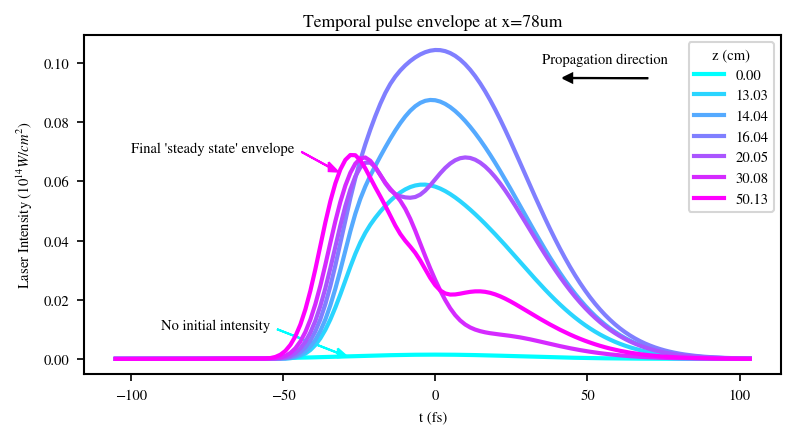

In [107]:
ind = np.array([0, 65, 70, 80, 100, 150, 250])

Nt = pulse.Nt
T = pulse.T
t = pulse.t
Nx = pulse.Nx
X = pulse.X
e = np.zeros((Nt, Nx), dtype='complex128')

i_x = int(Nx/2+16)
print('x=%0.1f' % (i_x/Nx*X-X/2))

plt.figure(figsize=(6, 3), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(ind))]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
for i in range(len(ind)):
    e[:, :] = pulse.load_field(ind[i])[0]
    I = ionization.intensity_from_field(e)
    I_max = np.amax(I)
    plt.plot(t, I[:, i_x], label='%0.2f' % (pulse.z[ind[i]]/1e4))
plt.legend(title='z (cm)')
plt.xlabel('t (fs)')
plt.ylabel(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.text(-90, 0.01, 'No initial intensity')
plt.arrow(-52, 0.01, 20, -0.008, head_width=0.003, head_length=3, color=colors[0], width=0.0001)
plt.text(-100, 0.07, "Final 'steady state' envelope")
plt.arrow(-44, 0.07, 9, -0.005, head_width=0.003, head_length=3, color=colors[-1], width=0.0001)
plt.text(35, 0.1, 'Propagation direction')
plt.arrow(70, 0.095, -25, 0, head_width=0.003, head_length=3, color='k', width=0.0001)
plt.title('Temporal pulse envelope at x=78um')
plt.show()

x=175.8


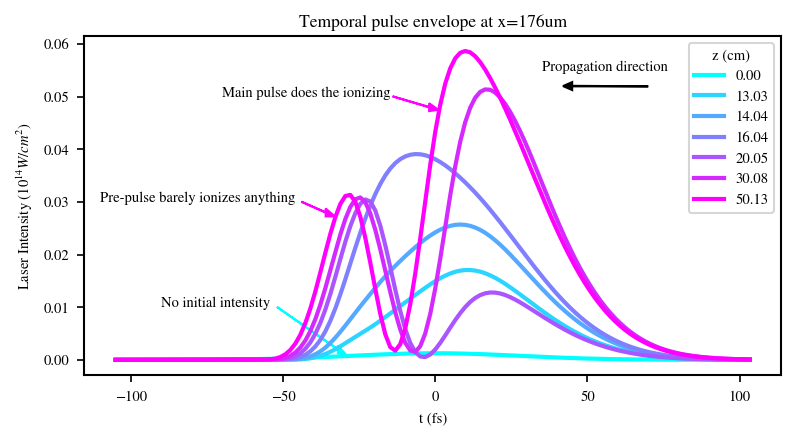

In [122]:
ind = np.array([0, 65, 70, 80, 100, 150, 250])

Nt = pulse.Nt
T = pulse.T
t = pulse.t
Nx = pulse.Nx
X = pulse.X
e = np.zeros((Nt, Nx), dtype='complex128')

i_x = int(Nx/2+36)
print('x=%0.1f' % (i_x/Nx*X-X/2))

plt.figure(figsize=(6, 3), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(ind))]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
for i in range(len(ind)):
    e[:, :] = pulse.load_field(ind[i])[0]
    I = ionization.intensity_from_field(e)
    I_max = np.amax(I)
    plt.plot(t, I[:, i_x], label='%0.2f' % (pulse.z[ind[i]]/1e4))
plt.legend(title='z (cm)')
plt.xlabel('t (fs)')
plt.ylabel(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.text(-90, 0.01, 'No initial intensity')
plt.arrow(-52, 0.01, 20, -0.008, head_width=0.0015, head_length=3, color=colors[0], width=0.0001)
plt.text(-110, 0.03, "Pre-pulse barely ionizes anything")
plt.arrow(-44, 0.03, 8, -0.002, head_width=0.0015, head_length=3, color=colors[-1], width=0.0001)
plt.text(-70, 0.05, "Main pulse does the ionizing")
plt.arrow(-14, 0.05, 12, -0.002, head_width=0.0015, head_length=3, color=colors[-1], width=0.0001)
plt.text(35, 0.055, 'Propagation direction')
plt.arrow(70, 0.052, -25, 0, head_width=0.0015, head_length=3, color='k', width=0.0001)
plt.title('Temporal pulse envelope at x=176um')
plt.show()

x=0.0


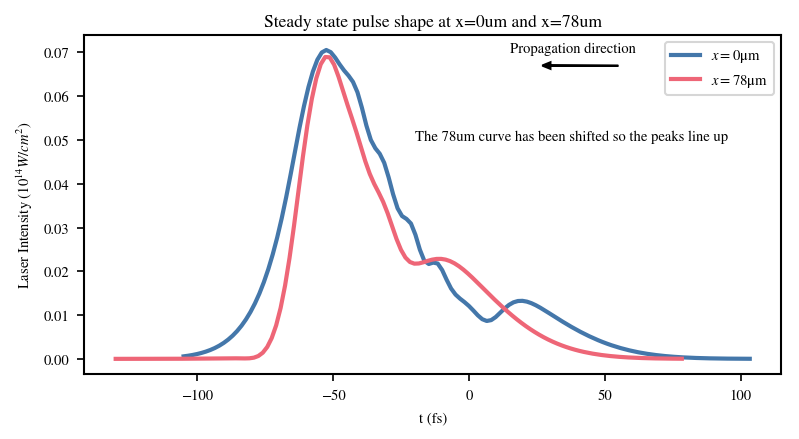

In [146]:
ind = 250

Nt = pulse.Nt
T = pulse.T
t = pulse.t
Nx = pulse.Nx
X = pulse.X
e = np.zeros((Nt, Nx), dtype='complex128')

i_x = int(Nx/2)
i_x2 = int(Nx/2+16)
print('x=%0.1f' % (i_x/Nx*X-X/2))

plt.figure(figsize=(6, 3), dpi=150)
#colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(ind))]
#ax = plt.subplot()
#ax.set_prop_cycle('color', colors)
e[:, :] = pulse.load_field(ind)[0]
I = ionization.intensity_from_field(e)
I_max = np.amax(I)
plt.plot(t, I[:, i_x], label=r'$x=0\mathrm{\mu m}$')
plt.plot(t-25, I[:, i_x2], label=r'$x=78\mathrm{\mu m}$')
plt.legend()
plt.xlabel('t (fs)')
plt.ylabel(r'Laser Intensity ($10^{14} W/cm^2$)')
plt.title('Steady state pulse shape at x=0um and x=78um')
plt.text(-20, 0.05, 'The 78um curve has been shifted so the peaks line up')
plt.text(15, 0.07, 'Propagation direction')
plt.arrow(55, 0.067, -25, 0, head_width=0.0015, head_length=3, color='k', width=0.0001)
plt.show()